Nome:Thiago da Costa Gadelha<br>Matrícula:499284

# Recapitulação - Texto Introdutório

O objetivo deste projeto é fazer um modelo preditivo que consiga avaliar quem estará no pódio do prêmio de MVP(Neste projeto considerei os 4 primeiros, mas a NBA considera os 3 primeiros assim como qualquer premiação) e quem será o MVP.

Para isso, irei extrair as estatísticas da temporada regular de todos os jogadores da temporada 1979-80 até a temporada 2020-2021 para fazer o aprendizado do modelo de ML.Neste scraping, extrairei os dados totais,os dados por jogo,os dados por 36 min, os dados por 100 posses ,is dados avançados e os dados do desempenho do time em que o jogador esteve na temporada.Os dados de 2021-2022 serão a entrada para avaliar se o meu modelo consegue acertar os 4 primeiros lugares do prêmio de mvp deste ano.

Além de todas essas colunas que serão geradas na extração,no modelo de dataset proposto por mim, coloco as colunas 'mvp_candidate', 'mvp_podium' e 'mvp_winner'.Estas colunas são valores boleanos para avaliar essas condições.Também coloco a coluna 'mvp_votes_share'(coluna que armazena número de pontos recebidos dividido por número de pontos máximo.Caso o jogador não seja candidato a mvp, esse valor é 0).

As colunas descritas nos parágrafos acima tem como objetivo tentar montar um dataset em que seja possível usar a regressão linear para fazer a predição.Uso como valor de "chave" nomejogador_temporada_time para conseguir diferenciar apropiadamente os jogadores entre si e os valores numéricos são todos fornecidos pelos dados estatísticos.O objetivo é tentar prever o dado numérico de 'mvp_votes_share' de forma que a ordem seja a mesma do prêmio.

Obs:Tenho impressão de que vai haver mvp_votes_share negativos mesmo com uma filtragem, mas espero que ao menos dê para acertar o pódio

Neste notebook extrairei os dados do site basketball reference(https://www.basketball-reference.com/) para criar um dataset a partir de dados da  temporada regular da NBA.

# Importando as bibliotecas e os dados obtidos no trabalho 1

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from scipy.stats import ranksums
import numpy as np

#Setando o padrão de cores a ser usado no seaborn
sns.set_palette('Accent')
sns.set_style('darkgrid')

#Setando uma opção do Pandas para mostrar todas as colunas na visualização do DataFrame
pd.set_option('display.max_columns', None)

#importando os dados dos jogadores
dados = pd.read_csv('data/dataset_jogadores.csv', sep = ';')

#Trocando o índice numérico para player_season_team para ficar mais fácil navegar pela base de dados
dados = dados.set_index('player_season_team', drop=True)

#Excluindo jogadores TOT
selecao = dados[dados.team == 'TOT'].index
dados.drop(selecao, inplace=True)

#selecionando apenas os candidatos a MVP em outro DataFrame para selecioná-los quando necessário
candidatos = dados[dados.mvp_candidate == True]

#Mostrando 5 linhas aleatórias do DataSet
dados.sample(5)

,player,season,pos,age,team,g,gs,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,fg2,fg2a,fg2_pct,efg_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,mp_pergame,fga_per_g,fg3_per_g,fg3a_per_g,fg2_per_g,fg2a_per_g,ft_per_g,fta_per_g,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,fga_per_mp,fg3_per_mp,fg3a_per_mp,fg2_per_mp,fg2a_per_mp,ft_per_mp,fta_per_mp,orb_per_mp,drb_per_mp,trb_per_mp,ast_per_mp,stl_per_mp,blk_per_mp,tov_per_mp,pf_per_mp,pts_per_mp,fga_per_poss,fg3_per_poss,fg3a_per_poss,fg2_per_poss,fg2a_per_poss,ft_per_poss,fta_per_poss,orb_per_poss,drb_per_poss,trb_per_poss,ast_per_poss,stl_per_poss,blk_per_poss,tov_per_poss,pf_per_poss,pts_per_poss,off_rtg,def_rtg,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,team_wins,team_losses,team_win_loss_pct,team_gb,team_pts_per_g,team_opp_pts_per_g,team_srs,mvp_candidate,mvp_podium,mvp_winner,mvp_votes_share
player_season_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RichardAnderson_1987_HOU,Richard Anderson,1987,PF,26,HOU,51,0.0,312,59,139,0.424,4,16,0.250,55,123,0.447,0.439,22,29,0.759,24,55,79,33,7,3,19,37,144,6.1,2.7,0.1,0.3,1.1,2.4,0.4,0.6,0.5,1.1,1.5,0.6,0.1,0.1,0.4,0.7,2.8,16.0,0.5,1.8,6.3,14.2,2.5,3.3,2.8,6.3,9.1,3.8,0.8,0.3,2.2,4.3,16.6,21.4,0.6,2.5,8.5,18.9,3.4,4.5,3.7,8.5,12.2,5.1,1.1,0.5,2.9,5.7,22.2,102.0,106.0,0.115,0.209,8.6,19.1,13.9,15.4,1.1,0.6,11.1,22.4,0.1,0.4,0.5,0.082,-0.8,-0.5,-1.3,0.1,42.0,40.0,0.512,13.0,106.9,105.9,0.60,False,False,False,0.0
ImeUdoka_2006_NYK,Ime Udoka,2006,SF,28,NYK,8,0.0,114,9,24,0.375,1,3,0.333,8,21,0.381,0.396,3,6,0.500,3,14,17,6,1,0,2,8,22,14.2,3.0,0.1,0.4,1.0,2.6,0.4,0.8,0.4,1.8,2.1,0.8,0.1,0.0,0.3,1.0,2.8,7.6,0.3,0.9,2.5,6.6,0.9,1.9,0.9,4.4,5.4,1.9,0.3,0.0,0.6,2.5,6.9,11.1,0.5,1.4,3.7,9.7,1.4,2.8,1.4,6.5,7.9,2.8,0.5,0.0,0.9,3.7,10.2,97.0,114.0,0.125,0.250,3.2,15.1,9.1,8.4,0.5,0.0,7.0,11.4,0.0,0.0,0.0,0.001,-3.3,-2.2,-5.4,-0.1,23.0,59.0,0.280,26.0,95.6,102.0,-6.30,False,False,False,0.0
EmanuelTerry_2019_MIA,Emanuel Terry,2019,PF,22,MIA,1,0.0,3,0,1,0.000,0,0,0.000,0,1,0.000,0.000,1,2,0.500,1,0,1,1,0,0,0,0,1,3.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0,12.0,12.0,24.0,12.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,12.0,16.3,0.0,0.0,0.0,16.3,16.3,32.6,16.3,0.0,16.3,16.3,0.0,0.0,0.0,0.0,16.3,105.0,117.0,0.000,2.000,35.4,0.0,17.7,40.5,0.0,0.0,0.0,26.8,0.0,0.0,0.0,0.045,5.9,-3.9,2.1,0.0,39.0,43.0,0.476,21.0,105.7,105.9,-0.45,False,False,False,0.0
BradMiller_2008_SAC,Brad Miller,2008,C,31,SAC,72,72.0,2513,337,728,0.463,28,90,0.311,309,638,0.484,0.482,262,309,0.848,167,514,681,264,69,74,164,247,964,34.9,10.1,0.4,1.3,4.3,8.9,3.6,4.3,2.3,7.1,9.5,3.7,1.0,1.0,2.3,3.4,13.4,10.4,0.4,1.3,4.4,9.1,3.8,4.4,2.4,7.4,9.8,3.8,1.0,1.1,2.3,3.5,13.8,14.7,0.6,1.8,6.2,12.9,5.3,6.2,3.4,10.4,13.7,5.3,1.4,1.5,3.3,5.0,19.4,112.0,107.0,0.124,0.424,8.0,23.7,16.0,16.6,1.4,2.3,16.0,18.3,3.8,2.7,6.5,0.125,0.9,0.8,1.7,2.3,38.0,44.0,0.463,19.0,102.5,104.8,-1.86,False,False,False,0.0
EarlWatson_2006_DEN,Earl Watson,2006,PG,26,DEN,46,10.0,975,121,282,0.429,68,172,0.395,53,110,0.482,0.550,37,59,0.627,17,69,86,160,37,7,75,95,347,21.2,6.1,1.5,3.7,1.2,2.4,0.8,1.3,0.4,1.5,1.9,3.5,0.8,0.2,1.6,2.1,7.5,10.4,2.5,6.4,2.0,4.1,1.4,2.2,0.6,2.5,3.2,5.9,1.4,0.3,2.8,3.5,12.8,14.8,3.6,9.0,2.8,5.8,1.9,3.1,0.9,3.6,4.5,8.4,1.9,0.4,3.9,5.0,18.2,105.0,108.0,0.610,0.209,2.1,8.2,5.2,25.3,1.9,0.5,19.6,17.6,0.8,0.8,1.6,0.080,0.2,-0.3,-0.1,0.4,44.0,38.0,0.537,0.0,100.3,100.1,0.36,False,False,False,0.0


# Explicando os atributos

## Atributos da base de dados

In [2]:
', '.join(dados.columns)

'player, season, pos, age, team, g, gs, mp, fg, fga, fg_pct, fg3, fg3a, fg3_pct, fg2, fg2a, fg2_pct, efg_pct, ft, fta, ft_pct, orb, drb, trb, ast, stl, blk, tov, pf, pts, mp_pergame, fga_per_g, fg3_per_g, fg3a_per_g, fg2_per_g, fg2a_per_g, ft_per_g, fta_per_g, orb_per_g, drb_per_g, trb_per_g, ast_per_g, stl_per_g, blk_per_g, tov_per_g, pf_per_g, pts_per_g, fga_per_mp, fg3_per_mp, fg3a_per_mp, fg2_per_mp, fg2a_per_mp, ft_per_mp, fta_per_mp, orb_per_mp, drb_per_mp, trb_per_mp, ast_per_mp, stl_per_mp, blk_per_mp, tov_per_mp, pf_per_mp, pts_per_mp, fga_per_poss, fg3_per_poss, fg3a_per_poss, fg2_per_poss, fg2a_per_poss, ft_per_poss, fta_per_poss, orb_per_poss, drb_per_poss, trb_per_poss, ast_per_poss, stl_per_poss, blk_per_poss, tov_per_poss, pf_per_poss, pts_per_poss, off_rtg, def_rtg, fg3a_per_fga_pct, fta_per_fga_pct, orb_pct, drb_pct, trb_pct, ast_pct, stl_pct, blk_pct, tov_pct, usg_pct, ows, dws, ws, ws_per_48, obpm, dbpm, bpm, vorp, team_wins, team_losses, team_win_loss_pct, team_gb, 

> ### Glossário dos atributos mais importantes
> ***

|Sigla|Definição|
|---|---|
|fga|Quantidade de arremessos tentados|
|fg|Quantidade de arremessos convertidos|
|ft|Quantidade de arremessos de lance livre|
|pts|Quantidade de pontos|
|drb|Quantidade de rebotes defensivos|
|tov|Quantidade de turnovers|
|pts_per_g|Pontos por jogo|
|pts_per_mp|Quantidade de pontos por minuto de jogo|
|pts_per_poss|Quantidade de pontos por posse|
|usg_pct|Porcentagem de jogadas do time que um jogador participou quando esteve em quadra|
|ows|Quantidade de jogadas ofensivas que o jogador contribuiu|
|dws|Quantidade de jogadas defensivas que o jogador contribuiu|
|ws|Quantidade de vitórias que o jogador contribuiu|
|bpm|Quantidade de pontos por 100 posses de quando o jogador esteve em quadra|

In [3]:
print(f"A base de dados tem {dados.shape[0]} linhas e {dados.shape[1]} colunas")
print(f"Destes dados, {dados[dados.mvp_candidate == True].shape[0]} são candidatos a MVP")

A base de dados tem 19109 linhas e 110 colunas
Destes dados, 676 são candidatos a MVP


Primeiro, precisa-se definir quem são os jogadores que poderiam disputar uma vaga a candidato a MVP entre todos os jogadores
da NBA, já que muitos nem são considerados.Logo, deve-se tentar definir parâmetros para excluir jogadores do dataset de forma a aumentar a sua qualidade.

# Análise de candidatos a MVP usando a média de minutos por jogo

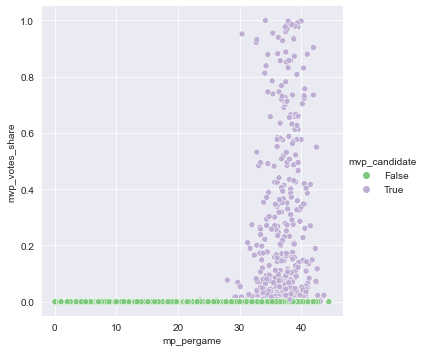

In [4]:
sns.relplot(x = 'mp_pergame', y = 'mvp_votes_share', hue = 'mvp_candidate' ,data = dados)

**Visualmente, apenas são considerados jogadores com mais de 20 minutos de média por jogo**

## Teste de Hipótese

**H<sup>null</sup>**
> **A distribuição da taxa da votação a MVP é a mesma nos dois grupos**

**H<sup>alt</sup>**
> **A distribuição da taxa da votação a MVP não é a mesma nos dois grupos**

In [5]:
mais20min = dados[dados.mp_pergame>=20].mvp_votes_share
menos20min = dados[dados.mp_pergame<20].mvp_votes_share

r = ranksums(mais20min, menos20min)

print(f"O valor do pvalue é {r.pvalue}")

O valor do pvalue é 2.5763893396535187e-18


Logo, a distribuição da taxa da votação a MVP não é a mesma nos dois grupos.Desta forma,como a correlação é extremamente baixa, a qualidade da análise da anostra torna-se maior usando apenas jogadores com mais de 20 minutos de média por jogo.

# Análise de candidatos a MVP usando a quantidade de partidas jogadas em uma temporada

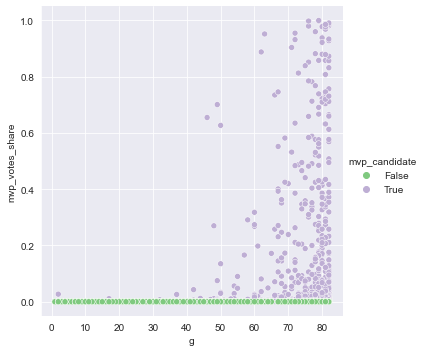

In [6]:
sns.relplot(x = 'g', y = 'mvp_votes_share', hue = 'mvp_candidate' ,data = dados)

**Visualmente, parece haver jogadores com um padrão de minutos por partida muito diferente dos demais, mas o geral é acima de 35 jogos**

## Teste de Hipótese

**H<sup>null</sup>**
> **A distribuição da taxa da votação a MVP é a mesma nos dois grupos**

**H<sup>alt</sup>**
> **A distribuição da taxa da votação a MVP não é a mesma nos dois grupos**

In [7]:
mais35jogos = dados[dados.g>=35].mvp_votes_share
menos35jogos = dados[dados.g<35].mvp_votes_share

r = ranksums(mais35jogos, menos35jogos)

print(f"O valor do pvalue é {r.pvalue}")

O valor do pvalue é 3.64823278198151e-09


Logo, a distribuição da taxa da votação a MVP não é a mesma nos dois grupos.Desta forma,como a correlação é extremamente baixa, a qualidade da análise da anostra torna-se maior usando apenas jogadores com mais de 35 jogos.

# Excluindo jogadores do DataSet para melhorar sua qualidade

In [8]:
selecao = dados[(dados.g < 35) | (dados.mp_pergame<20)].index
candidatosPossiveis = dados.drop(selecao)

candidatosPossiveis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8035 entries, KareemAbdul-Jabbar_1980_LAL to CodyZeller_2020_CHO
Columns: 110 entries, player to mvp_votes_share
dtypes: float64(83), int64(21), object(6)
memory usage: 6.8+ MB


Daí, percebe-se a diminuição substancial do dataset para considerar apenas jogadores que talvez poderiam se chamados.

Agora, deve-se tentar avaliar se há atributos que influenciam diretamente na votação de mvp.

# Matriz de Correlação

**Parâmetro para considerar determinado atributo:Correlação com mvp_votes_share acima de 25%.**

<AxesSubplot:>

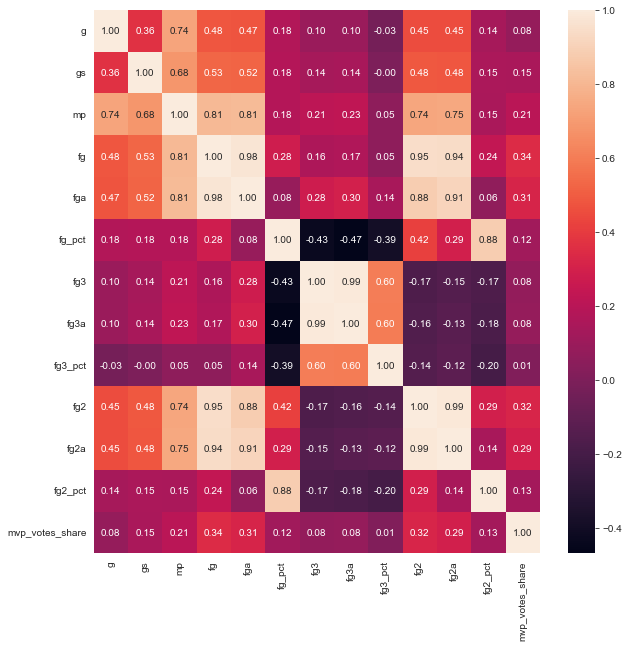

In [9]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'fg2', 'fg2a', 'fg2_pct',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:fg, fga,fg2,fg2a.
fg e fga são extremamente correlacionados, logo só vale a pena destacar **fg**,pois poderia haver dados redundantes, e por ter uma correlação maior com mvp_votes_share.
De forma análoga, so será considerado **fg2**

<AxesSubplot:>

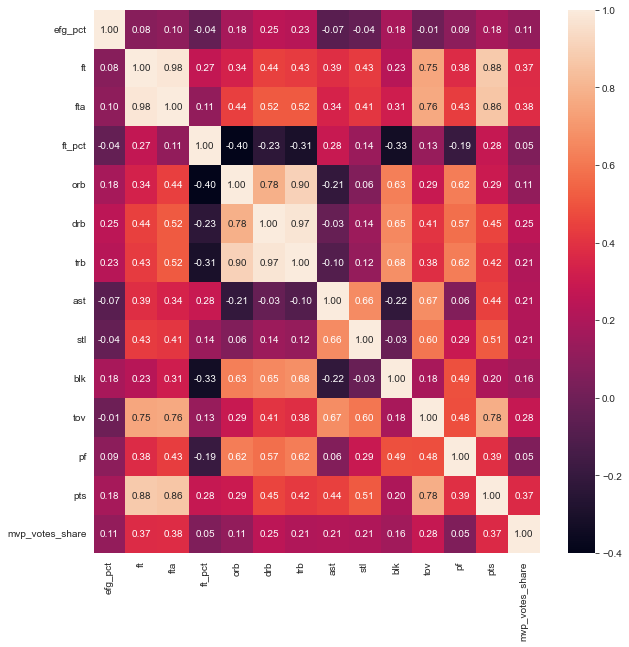

In [10]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['efg_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:ft, fta,**drb**,**tov**,**pts**.
ft e fta são extremamente correlacionados, logo só vale a pena destacar **fta**,pois poderia haver dados redundantes, e por ter uma correlação maior com mvp_votes_share.

<AxesSubplot:>

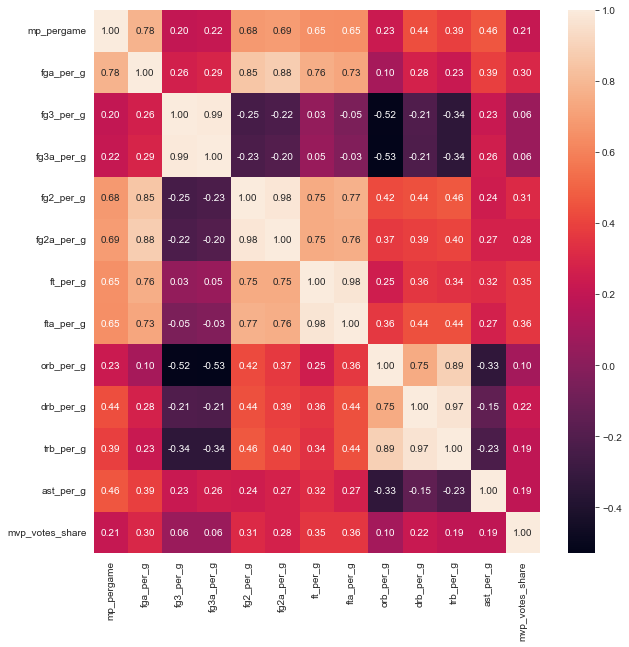

In [11]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['mp_pergame', 'fga_per_g', 'fg3_per_g', 'fg3a_per_g', 'fg2_per_g', 'fg2a_per_g', 'ft_per_g', 
                                 'fta_per_g', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:**fga_per_g**, fg2_per_g,fg2a_per_g,ft_per_g,fta_per_g
fg2_per_g e fg2a_per_g são extremamente correlacionados, logo só vale a pena destacar **fg2_per_g**,pois poderia haver dados redundantes, e por ter uma correlação maior com mvp_votes_share.
De forma análoga, so será considerado **fta_per_g**

<AxesSubplot:>

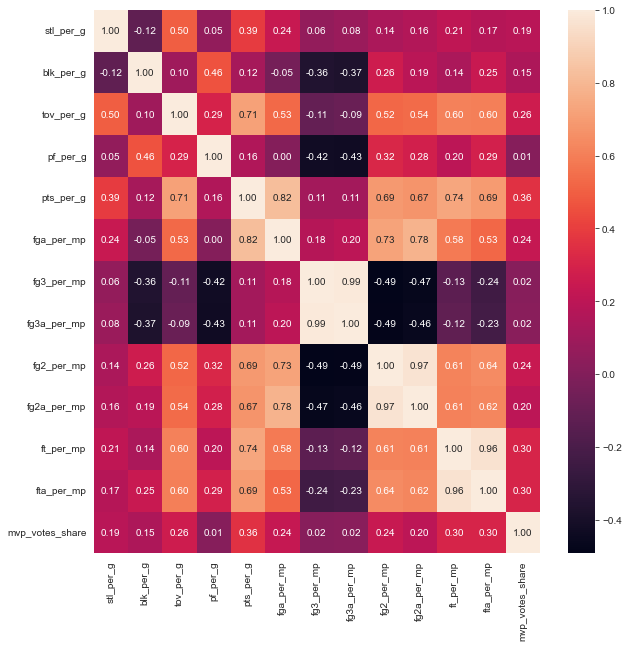

In [12]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'fga_per_mp', 'fg3_per_mp', 
                                 'fg3a_per_mp', 'fg2_per_mp', 'fg2a_per_mp', 'ft_per_mp', 'fta_per_mp',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:**tov_per_g**, **pts_per_g**,ft_per_mp,fta_per_mp
ft_per_mp e fta_per_mp são extremamente correlacionados, logo só vale a pena destacar **fta_per_mp**,pois poderia haver dados redundantes, e para manter uma coesão com as escolhas anteriores.

<AxesSubplot:>

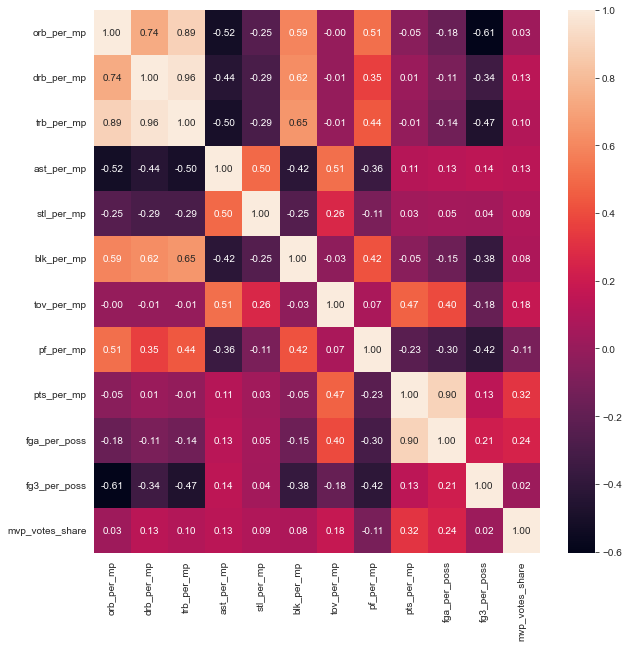

In [13]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['orb_per_mp', 'drb_per_mp', 'trb_per_mp', 'ast_per_mp', 'stl_per_mp', 'blk_per_mp', 
                                 'tov_per_mp', 'pf_per_mp', 'pts_per_mp', 'fga_per_poss', 'fg3_per_poss',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:**pts_per_mp**

<AxesSubplot:>

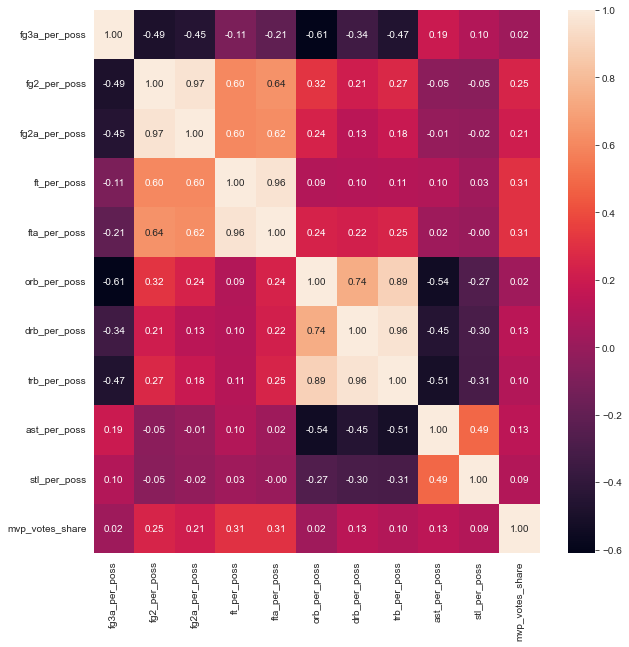

In [14]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['fg3a_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'ft_per_poss', 'fta_per_poss', 'orb_per_poss'
                                 , 'drb_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:**fg2_per_poss**, **ft_per_poss**,**fta_per_poss**
ft_per_poss e fta_per_poss são extremamente correlacionados, logo só vale a pena destacar **fta_per_poss**,pois poderia haver dados redundantes, e para manter uma coesão com as escolhas anteriores.

<AxesSubplot:>

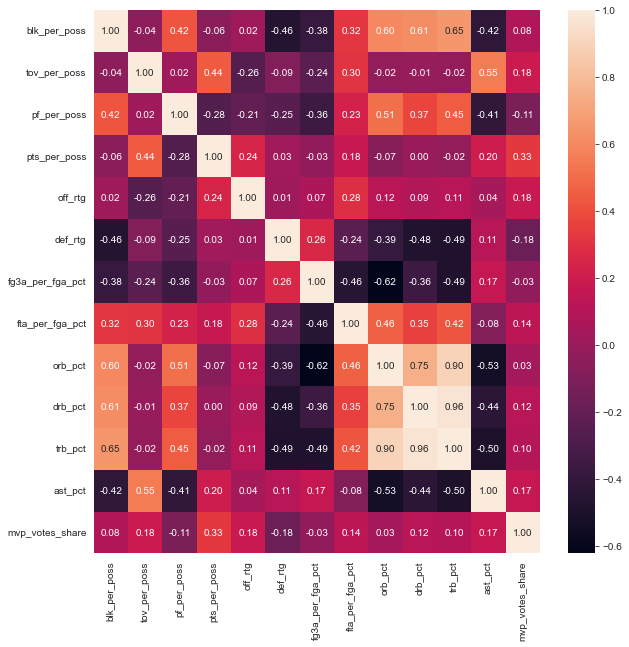

In [15]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg',
                                 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:**pts_per_poss**

<AxesSubplot:>

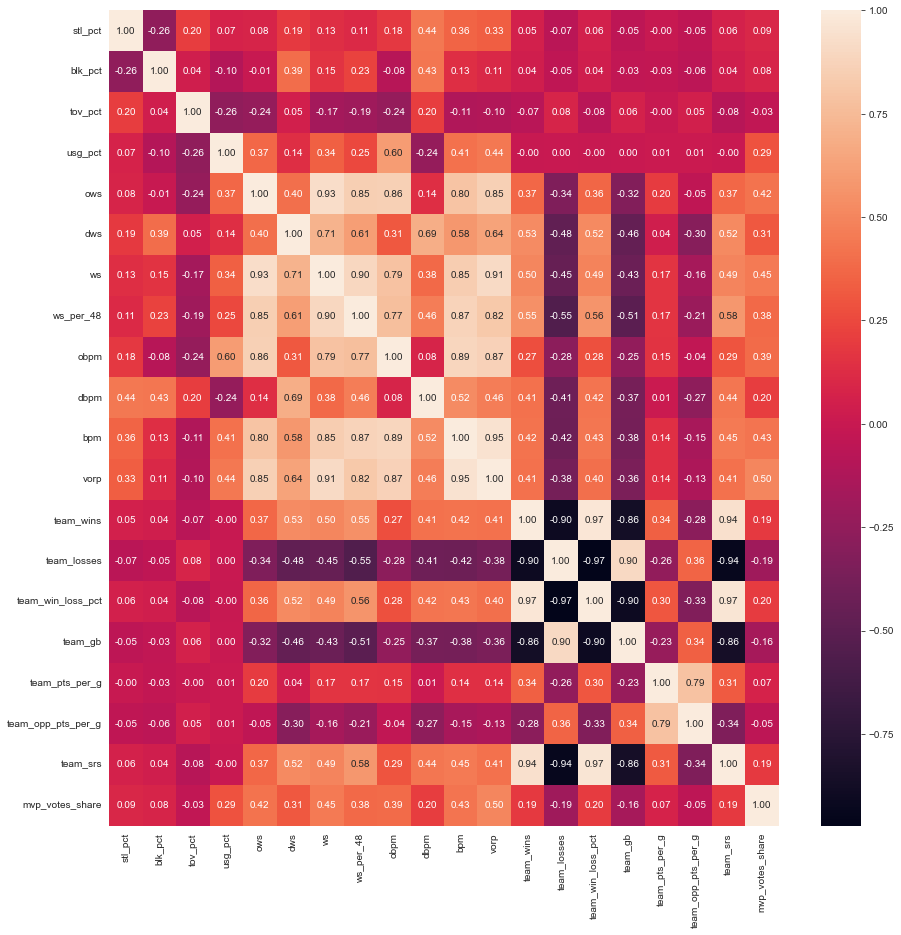

In [16]:
pyplot.figure(figsize=(15,15))
sns.heatmap(candidatosPossiveis[['stl_pct','blk_pct','tov_pct','usg_pct','ows','dws', 'ws', 'ws_per_48', 'obpm', 'dbpm', 'bpm'
                                 ,'vorp', 'team_wins', 'team_losses', 'team_win_loss_pct', 'team_gb', 'team_pts_per_g', 
                                 'team_opp_pts_per_g', 'team_srs',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

De acordo com a matriz de correlação, valeria a pena fazer uma análise mais a fundo dos seguintes atributos:**usg_pct**, **ows**, **dws**, **ws**, **ws_per_48**, **obpm**, **bpm**, **vorp**.

Os atributos que demonstraram ser uma ótima fonte de análise são os seguintes:**fg**, **fg2**, **fta**, **drb**, **tov**, **pts**, **fg2_per_g**, **fta_per_g**, **fga_per_g**, **tov_per_g**, **pts_per_g**,**fta_per_mp**, **pts_per_mp**, **fg2_per_poss**, **pts_per_poss**, **usg_pct**, **ows**, **dws**, **ws**, **ws_per_48**, **obpm**, **bpm**, **vorp**.

## Analisando os atributos selecionados

Agora, deve-se olhar a correlação entre esses atributos e analisar qual tem a maior correlação com mvp_votes_share, pois pode haver dados redundantes entre os selecionados.

<AxesSubplot:>

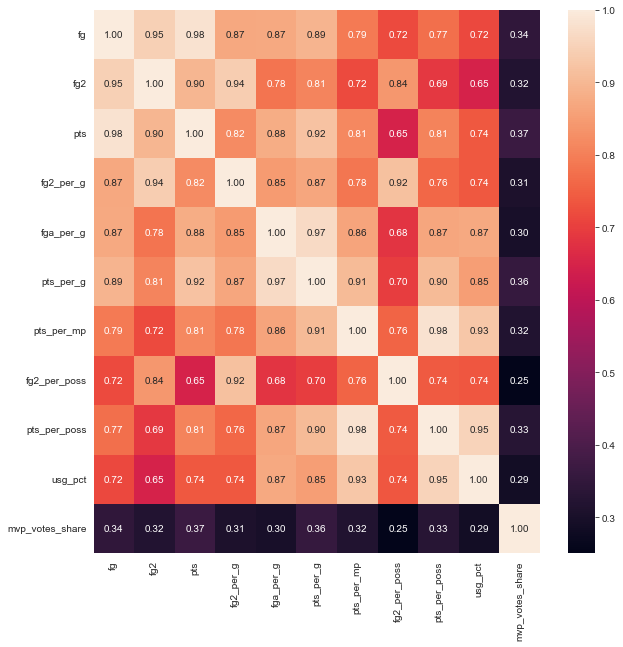

In [17]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['fg', 'fg2','pts', 'fg2_per_g', 'fga_per_g', 
                                 'pts_per_g', 'pts_per_mp', 'fg2_per_poss', 'pts_per_poss', 'usg_pct',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

1. fg e fg2 estão altamente correlacionados, porém é o esperado, já que quanto mais arremessos forem feitos,mais arremessos de 2 pontos serão feitos, e, como a pontuação entre os arremessos pode ser diferente, estes dois atributos servem para avaliar coisas diferentes, logo podem ser mantidos em conjunto.
2. De forma análoga, fga_per_g se relaciona aos atributos acima.Ele será mantido, pois é um atributo interessante para avaliar quanto lhe é permitido tentar jogadas de ataque.
3. fg2, fg2_per_g, fg2_per_poss são relativos ao número de arremessos de 2 pontos,logo estão altamente correlacionados.Apesar disso, pode-se manter ou fg2_per_g ou fg2_per_poss, pois é uma forma de avaliar a quantidade de arremessos de 2 pontos na perspectiva do quão participativo o jogador é, e isto é uma maneira de medir sua importãncia no ataque do time, pois não lhe seria permitido participar tanto, caso fosse um jogador com características diferentes ou um jogador secundário.Como fg2_per_game tem uma correlação maior com mvp_votes_share, ele será o atributo mantido.
4. De forma análoga, será mantido pts e pts_per_g.
5. usg_pct avalia a porcentagem de jogadas que o jogador esteve envolvido quando estava em quadra, logo é evidente que tem correlação entre um arremesso e esse atributo, já que muitos jogadas são construidas coletivamente.Mesmo assim , usg_pct precisa ser mantido, pois avalia outros aspectos como passe e posicionamento para a construção de uma jogada.

<AxesSubplot:>

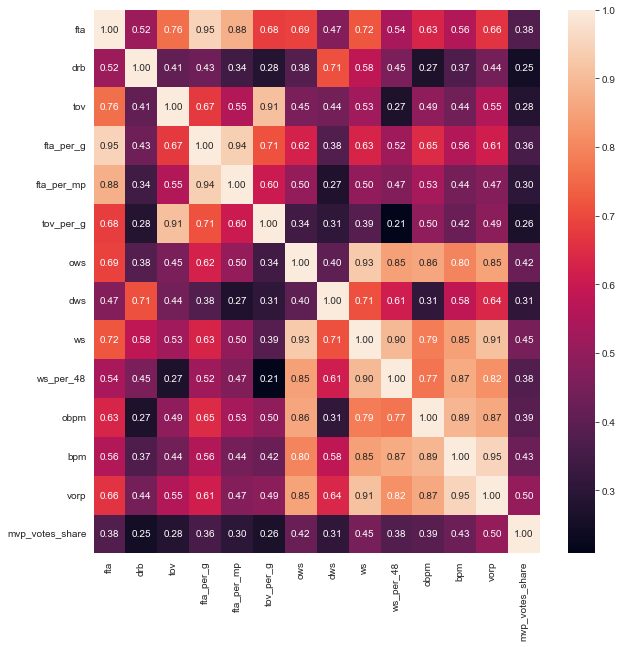

In [18]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[['fta', 'drb', 'tov','fta_per_g', 'fta_per_mp','tov_per_g','ows', 'dws'
                                 , 'ws', 'ws_per_48', 'obpm', 'bpm', 'vorp',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

6. De forma análoga à 3., dentre fta, fta_per_mp e fta_per_g, serão escolhidos fta e fta_per_mp.
7. Apesar de certos atributos(ows,dws,ws,obpm,bpm,vorp) serem altamente correlacionados , isso é normal e eles avaliam coisas diferentes.

**Logo, os atributos selecionados são:'fg', 'fg2','pts', 'fg2_per_g', 'fga_per_g', 'pts_per_g', 'usg_pct', 'fta', 'drb', 'tov','fta_per_g', 'fta_per_mp','tov_per_g','ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'bpm', 'vorp'**

Agora fica a questão: Será que foram perdidos atributos importantes para a análise?Isso será discutido a seguir:

# Mostrando a distribuição de candidatos a MVP por Posição em cada temporada

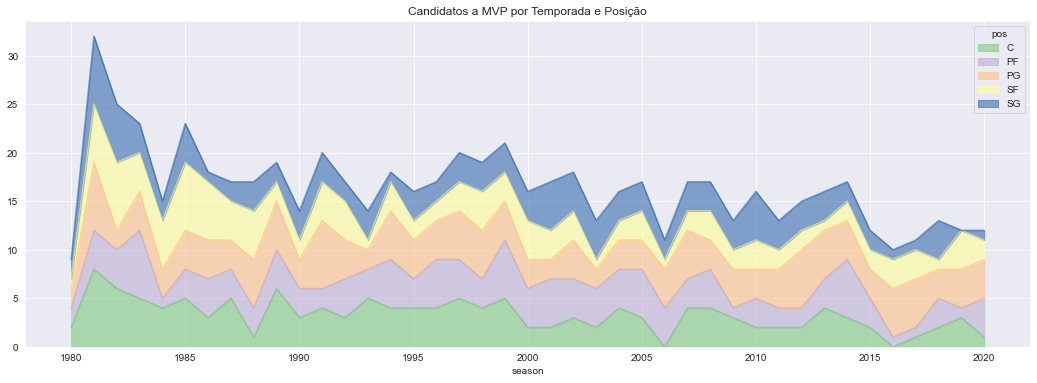

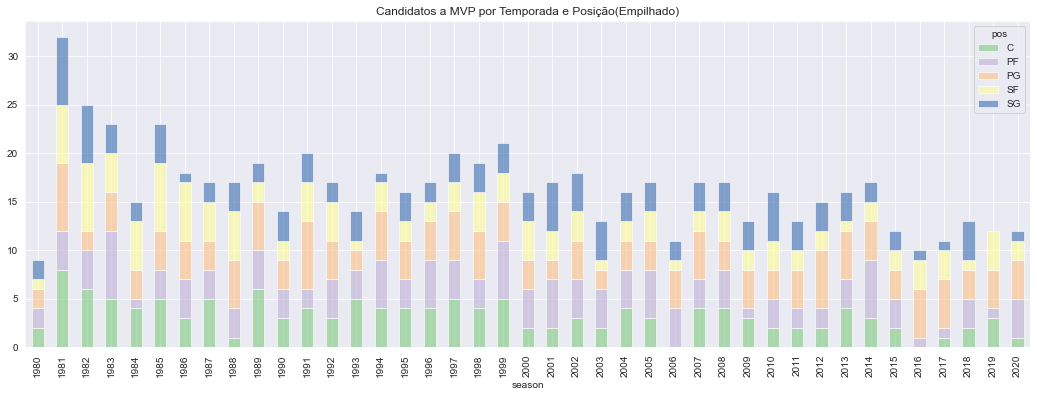

In [19]:
agrupandoPorPosicao = dados.groupby(['season','pos'])[["mvp_candidate", "mvp_podium", "mvp_winner"]].sum().unstack()
agrupandoPorPosicao.plot(kind='area', y="mvp_candidate", figsize=(18, 6), title='Candidatos a MVP por Temporada e Posição', alpha=0.6, stacked=True)
pyplot.show()
agrupandoPorPosicao.plot(kind='bar', y="mvp_candidate", figsize=(18, 6), title='Candidatos a MVP por Temporada e Posição(Empilhado)', alpha=0.6, stacked=True)
pyplot.show()

**Visualmente, há uma alteração entre períodos.Para avaliar isso melhor , seria necessário outro tipo de análise que não cabe a este projeto, pois seria necessário analisar como está o jogo, como são os posicionamentos da maioria das jogadas e detalhes a mais que estão além do escopo para analisar quais são os fatores que levam a essa diferença.Aqui não será analisado se a posição interfere.**

# Mostrando mudança de estatísticas na NBA

Nesta seção, será feita uma análise de algumas estatísticas chaves para comparar como suas médias entre os candidatos que 
poderiam ser considerados e os candidatos a MVP ao longo das temporadas da NBA

In [20]:
agrupandoPorAnoPossiveis = candidatosPossiveis.groupby(['season'])[['fg3_pct','fg_pct', 'efg_pct', 'tov_per_g', 
                                                           'pts_per_poss']].mean()
agrupandoPorAnoPossiveis.reset_index(inplace = True)
agrupandoPorAnoPossiveis


,season,fg3_pct,fg_pct,efg_pct,tov_per_g,pts_per_poss
0,1980,0.163006,0.487025,0.490924,2.317834,21.611465
1,1981,0.152775,0.487680,0.490095,2.242604,21.515976
2,1982,0.181423,0.494865,0.498282,2.103681,22.066871
3,1983,0.149443,0.490139,0.493259,2.297468,21.815190
4,1984,0.158209,0.497513,0.500703,2.154430,22.169620
5,1985,0.163285,0.497962,0.502089,2.170886,22.427215
6,1986,0.149525,0.496363,0.501075,2.126875,22.203125
7,1987,0.174823,0.484524,0.492543,2.034756,21.889024
8,1988,0.198078,0.483455,0.493162,1.981437,22.257485
9,1989,0.202370,0.481757,0.494064,2.101156,22.017341


In [21]:
agrupandoPorAnoCand = candidatos.groupby(['season'])[['fg3_pct','fg_pct', 'efg_pct', 'tov_per_g', 
                                                           'pts_per_poss']].mean()
agrupandoPorAnoCand.reset_index(inplace=True)
agrupandoPorAnoCand

,season,fg3_pct,fg_pct,efg_pct,tov_per_g,pts_per_poss
0,1980,0.171444,0.501333,0.505556,3.144444,28.866667
1,1981,0.177656,0.509094,0.510781,2.812500,25.706250
2,1982,0.162400,0.516880,0.518200,2.944000,28.620000
3,1983,0.130783,0.517870,0.519478,3.008696,27.221739
4,1984,0.177000,0.519067,0.521400,3.053333,29.253333
5,1985,0.183130,0.500435,0.505870,3.000000,29.165217
6,1986,0.143944,0.514500,0.519000,2.983333,28.366667
7,1987,0.168647,0.510176,0.515588,3.023529,31.229412
8,1988,0.254706,0.504706,0.516706,2.911765,29.905882
9,1989,0.210789,0.516053,0.523737,3.094737,27.647368


## Aproveitamento do arremesso de 3 pontos

Conforme mostrado nos gráficos abaixo, tanto a quantidade de arremesso de 3 pontos tentados quanto o aproveitamento desses arremessos aumentou muito ao longo dos anos na NBA.A questão que fica para a análise é: Será que a votação para MVP leva em conta apenas esse aumento devido às mudanças nas características do jogo ou se há um peso a mais.

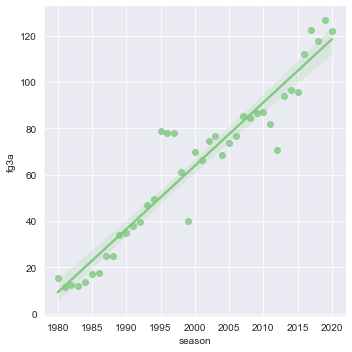

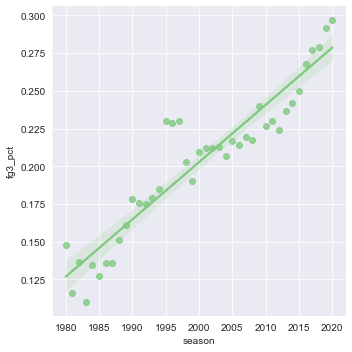

In [22]:
selecao = dados.groupby(['season'])[['fg3a', 'fg3_pct']].mean()
selecao.reset_index(inplace = True)
sns.lmplot(x = 'season', y = 'fg3a', data = selecao)
sns.lmplot(x = 'season', y = 'fg3_pct', data = selecao)

### Mostrando os aproveitamentos ao longo dos anos

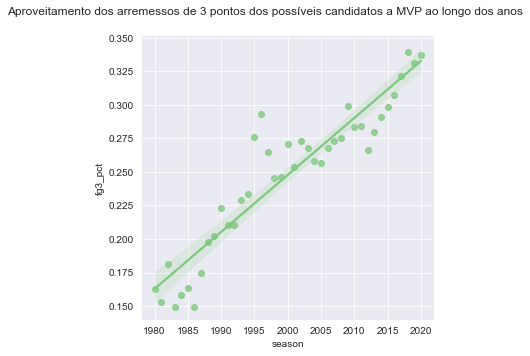

In [23]:
ax = sns.lmplot(x = 'season', y = 'fg3_pct', data = agrupandoPorAnoPossiveis)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Aproveitamento dos arremessos de 3 pontos dos possíveis candidatos a MVP ao longo dos anos')
ax

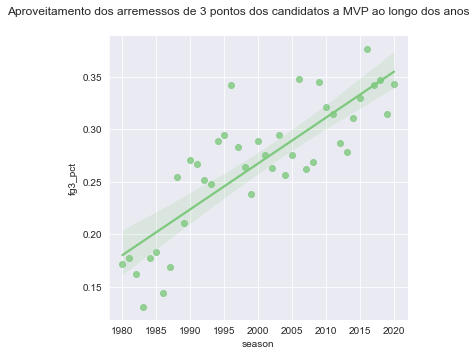

In [24]:
ax = sns.lmplot(x = 'season', y = 'fg3_pct', data = agrupandoPorAnoCand)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Aproveitamento dos arremessos de 3 pontos dos candidatos a MVP ao longo dos anos')
ax

Parecem ser bem semelhantes ,mas não há como confirmar dessa forma.Vamos tentar analisar a correlação entre arremessos de 3 e mvp_votes_share na nba moderna.

<AxesSubplot:>

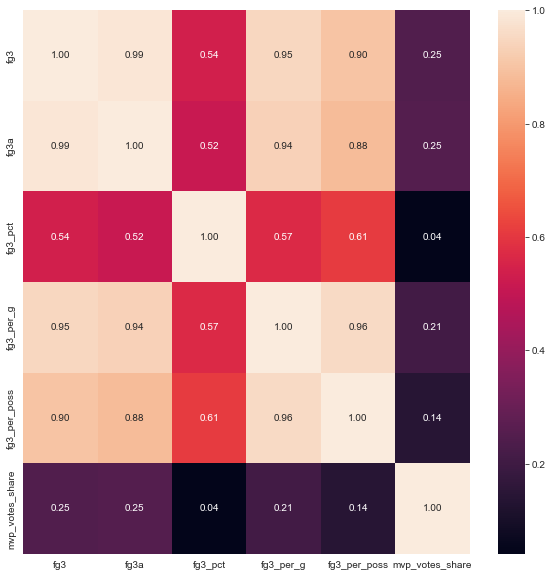

In [25]:
pyplot.figure(figsize=(10,10))
sns.heatmap(candidatosPossiveis[candidatosPossiveis.season > 2014][['fg3','fg3a','fg3_pct','fg3_per_g','fg3_per_poss',
                                 'mvp_votes_share']].corr(), annot=True, fmt='.2f')

Note que para o nosso modelo os arremessos de 3 não serão tão relevantes, já que mesmo na nba moderna, a correlação com mvp_votes_share apenas é igual ao minímo do que considerariamos.Então, para este modelo, os arremessos de 3 pontos não serão considerados.

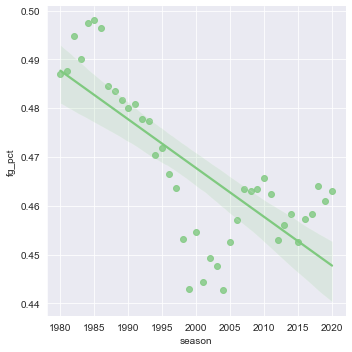

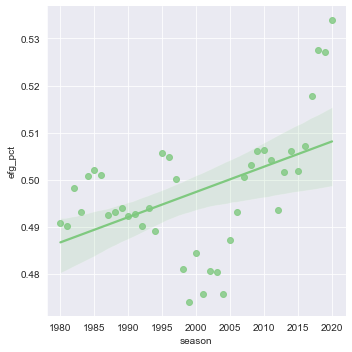

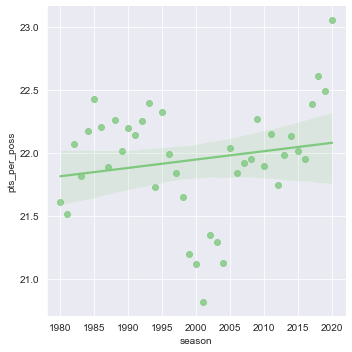

In [26]:
sns.lmplot(x = 'season', y = 'fg_pct', data = agrupandoPorAnoPossiveis)
sns.lmplot(x = 'season', y = 'efg_pct', data = agrupandoPorAnoPossiveis)
sns.lmplot(x = 'season', y = 'pts_per_poss', data = agrupandoPorAnoPossiveis)

É intetessante notar que, apesar do aproveitamento ter diminuido, a eficiência e os pontos por posse aumentaram. Isso se deve justamente à mudança para um estilo de jogo com mais arremessos de 3 pontos, pois os arremessos valem mais que cestas de meia distância e são mais difíceis.Para se fazer uma análise mais detalhada deve-se considerar o posicionamento dos arremessos de 2 pontos.

# Conclusão

A partir de nosso modelo, pode-se inferir que a premiação de votação de MVP levam mais em conta aspectos de quão importantes os jogadores são para as jogadas ofensivas e defensivas de forma direta.

# Salvando o novo dataset

In [27]:
candidatosPossiveis.to_csv('data/dataset_jogadores_melhorado.csv', sep = ',')